Import libraries

In [ ]:
# Import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D
from tensorflow.keras.models import Sequential
import cv2 as cv
import os
from sklearn.model_selection import train_test_split

In [ ]:
runtime_location = 'colab' # 'local' or 'colab'
directory_header = 'drive/MyDrive/Hology/' if runtime_location == 'colab' else './'

if runtime_location == 'colab':
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


Load train csv data

In [ ]:
# Load Train CSV

TRAIN_CSV_PATH = directory_header + 'dataset/train.csv'

df_train = pd.read_csv(TRAIN_CSV_PATH)

df_train.head()

id  jenis  warna
0   1      1      1
1   2      0      2
2   3      1      3
3   4      1      1
4   5      0      4

Load train image data

In [ ]:
# Load Train Images

X_raw_rgb = []
X_raw_gray = []
Y_shape = []
Y_color = []

TRAIN_IMG_PATH = directory_header + 'dataset/train/'

target_size = (224, 224)


for idx, file in enumerate(os.listdir(TRAIN_IMG_PATH)):

    file_path = os.path.join(TRAIN_IMG_PATH, file)

    # Load data in RGB format for color classification
    image_rgb = tf.keras.preprocessing.image.load_img(file_path, color_mode='rgb', target_size=target_size)
    image_rgb = tf.keras.preprocessing.image.img_to_array(image_rgb)
    # Load data in grayscale format for color classification
    image_gray = tf.keras.preprocessing.image.load_img(file_path, color_mode='grayscale', target_size=target_size)
    image_gray = tf.keras.preprocessing.image.img_to_array(image_gray)

    # Get file name
    file_id = os.path.splitext(file)[0]

    # Extract matching row, where id == name from train.csv
    matching_row = df_train[df_train['id'] == int(file_id)]

    if not matching_row.empty:
        X_raw_rgb.append(image_rgb)
        X_raw_gray.append(image_gray)
        Y_shape.append(matching_row['jenis'].values[0])
        Y_color.append(matching_row['warna'].values[0])
    else:
        print(f"No matching row found for file {file}")


# Convert to numpy array for easier manipulation
X_raw_gray = np.array(X_raw_gray)
X_raw_rgb = np.array(X_raw_rgb)
Y_shape = np.array(Y_shape)
Y_color = np.array(Y_color)

Preprocessing

In [ ]:
# Check X, Y shape

print(f'X_rgb shape: {X_raw_rgb.shape}')
print(f'X_gray shape: {X_raw_gray.shape}')
print(f'Y_shape shape: {Y_shape.shape}')
print(f'Y_color shape: {Y_color.shape}\n')

# Check Y classes

shape_classes = np.unique(Y_shape)
color_classes = np.unique(Y_color)

print(f'Shape classes: {shape_classes}')
print(f'Color classes: {color_classes}')

X_rgb shape: (777, 224, 224, 3)
X_gray shape: (777, 224, 224, 1)
Y_shape shape: (777,)
Y_color shape: (777,)

Shape classes: [0 1]
Color classes: [0 1 2 3 4]


In [ ]:
# Normalize X by pixel value

X_rgb_normalized = X_raw_rgb / 255
X_gray_normalized = X_raw_gray / 255

print(f'X rgb normalized minimum: {X_rgb_normalized.min()} | maximum: {X_rgb_normalized.max()}')
print(f'X gray normalized minimum: {X_gray_normalized.min()} | maximum: {X_gray_normalized.max()}')

X rgb normalized minimum: 0.0 | maximum: 1.0
X gray normalized minimum: 0.0 | maximum: 1.0


Label Classes

In [ ]:
# Dictionary for label (based on kaggle's data)

index_to_shape_dict = {0 : 'Kaos', 1 : 'Hoodie'}
index_to_color_dict = {0: 'Merah', 1: 'Kuning', 2: 'Biru', 3: 'Hitam', 4: 'Putih'}

One-Hot Encoding

In [ ]:
# Apply One hot encoding for Y_color (multi-class / more than 2)

def one_hot_encoding(Y: np.array, num_classes: int) -> np.array:

    encoded = tf.keras.utils.to_categorical(Y, num_classes= num_classes)

    return encoded

color_num_classes = color_classes.shape[0]

Y_color_encoded = one_hot_encoding(Y_color, color_num_classes)

print(Y_color_encoded.shape)

(777, 5)


Split data

In [ ]:
# train test val split
# 80% train, 10% test, 10% val

X_rgb_normalized_hoodie = X_rgb_normalized[Y_shape == 1]
X_gray_normalized_hoodie = X_gray_normalized[Y_shape == 1]
Y_shape_hoodie = Y_shape[Y_shape == 1]
Y_color_encoded_hoodie = Y_color_encoded[Y_shape == 1]

X_rgb_normalized_kaos = X_rgb_normalized[Y_shape == 0][:len(X_rgb_normalized_hoodie)]
X_gray_normalized_kaos = X_gray_normalized[Y_shape == 0][:len(X_rgb_normalized_hoodie)]
Y_shape_kaos = Y_shape[Y_shape == 0][:len(X_rgb_normalized_hoodie)]
Y_color_encoded_kaos = Y_color_encoded[Y_shape == 0][:len(X_rgb_normalized_hoodie)]

# dataset split untuk yang rgb dulu (untuk model color classification)
X_rgb_kaos_train, X_rgb_kaos_temp, Y_color_encoded_kaos_train, Y_color_encoded_kaos_temp = train_test_split(X_rgb_normalized_kaos, Y_color_encoded_kaos, test_size=0.2, random_state=42)

X_rgb_kaos_test, X_rgb_kaos_val, Y_color_encoded_kaos_test, Y_color_encoded_kaos_val = train_test_split(X_rgb_kaos_temp, Y_color_encoded_kaos_temp, test_size=0.5, random_state=42)

X_rgb_hoodie_train, X_rgb_hoodie_temp, Y_color_encoded_hoodie_train, Y_color_encoded_hoodie_temp = train_test_split(X_rgb_normalized_hoodie, Y_color_encoded_hoodie, test_size=0.2, random_state=42)

X_rgb_hoodie_test, X_rgb_hoodie_val, Y_color_encoded_hoodie_test, Y_color_encoded_hoodie_val = train_test_split(X_rgb_hoodie_temp, Y_color_encoded_hoodie_temp, test_size=0.5, random_state=42)

X_rgb_train = np.concatenate([X_rgb_kaos_train, X_rgb_hoodie_train])
Y_color_encoded_train = np.concatenate([Y_color_encoded_kaos_train, Y_color_encoded_hoodie_train])

X_rgb_val = np.concatenate([X_rgb_kaos_val, X_rgb_hoodie_val])
Y_color_encoded_val = np.concatenate([Y_color_encoded_kaos_val, Y_color_encoded_hoodie_val])

X_rgb_test = np.concatenate([X_rgb_kaos_test, X_rgb_hoodie_test])
Y_color_encoded_test = np.concatenate([Y_color_encoded_kaos_test, Y_color_encoded_hoodie_test])


# dataset split untuk yang grayscale (untuk model shape classification)
X_gray_kaos_train, X_gray_kaos_temp, Y_shape_kaos_train, Y_shape_kaos_temp = train_test_split(X_gray_normalized_kaos, Y_shape_kaos, test_size=0.2, random_state=42)

X_gray_kaos_test, X_gray_kaos_val, Y_shape_kaos_test, Y_shape_kaos_val = train_test_split(X_gray_kaos_temp, Y_shape_kaos_temp, test_size=0.5, random_state=42)

X_gray_hoodie_train, X_gray_hoodie_temp, Y_shape_hoodie_train, Y_shape_hoodie_temp = train_test_split(X_gray_normalized_hoodie, Y_shape_hoodie, test_size=0.2, random_state=42)

X_gray_hoodie_test, X_gray_hoodie_val, Y_shape_hoodie_test, Y_shape_hoodie_val = train_test_split(X_gray_hoodie_temp, Y_shape_hoodie_temp, test_size=0.5, random_state=42)

X_gray_train = np.concatenate([X_gray_kaos_train, X_gray_hoodie_train])
Y_shape_train = np.concatenate([Y_shape_kaos_train, Y_shape_hoodie_train])

X_gray_val = np.concatenate([X_gray_kaos_val, X_gray_hoodie_val])
Y_shape_val = np.concatenate([Y_shape_kaos_val, Y_shape_hoodie_val])

X_gray_test = np.concatenate([X_gray_kaos_test, X_gray_hoodie_test])
Y_shape_test = np.concatenate([Y_shape_kaos_test, Y_shape_hoodie_test])

# Check shape

print(f"X_rgb_train shape: {X_rgb_train.shape} | test: {X_rgb_test.shape} | val: {X_rgb_val.shape}")
print(f"Y_color_encoded_train shape: {Y_color_encoded_train.shape} | test: {Y_color_encoded_test.shape} | val: {Y_color_encoded_val.shape}")

print(f"X_gray_train shape: {X_gray_train.shape} | test: {X_gray_test.shape} | val: {X_gray_val.shape}")
print(f"Y_shape_train shape: {Y_shape_train.shape} | test: {Y_shape_test.shape} | val: {Y_shape_val.shape}")

X_rgb_train shape: (480, 224, 224, 3) | test: (60, 224, 224, 3) | val: (62, 224, 224, 3)
Y_color_encoded_train shape: (480, 5) | test: (60, 5) | val: (62, 5)
X_gray_train shape: (480, 224, 224, 1) | test: (60, 224, 224, 1) | val: (62, 224, 224, 1)
Y_shape_train shape: (480,) | test: (60,) | val: (62,)


Shuffle dataset

In [ ]:
from sklearn.utils import shuffle

# Shuffle the training set
X_rgb_train, Y_color_encoded_train = shuffle(X_rgb_train, Y_color_encoded_train, random_state=0)
X_rgb_val, Y_color_encoded_val = shuffle(X_rgb_val, Y_color_encoded_val, random_state=0)
X_rgb_test, Y_color_encoded_test = shuffle(X_rgb_test, Y_color_encoded_test, random_state=0)

X_gray_train, Y_shape_train = shuffle(X_gray_train, Y_shape_train, random_state=0)
X_gray_val, Y_shape_val = shuffle(X_gray_val, Y_shape_val, random_state=0)
X_gray_test, Y_shape_test = shuffle(X_gray_test, Y_shape_test, random_state=0)

<h1>Shape classifier modelling</h1>

In [ ]:
SHAPE_CLASSIFIER_INPUT_SHAPE = X_gray_train[0].shape
print(SHAPE_CLASSIFIER_INPUT_SHAPE)

(224, 224, 1)


Plot sample data

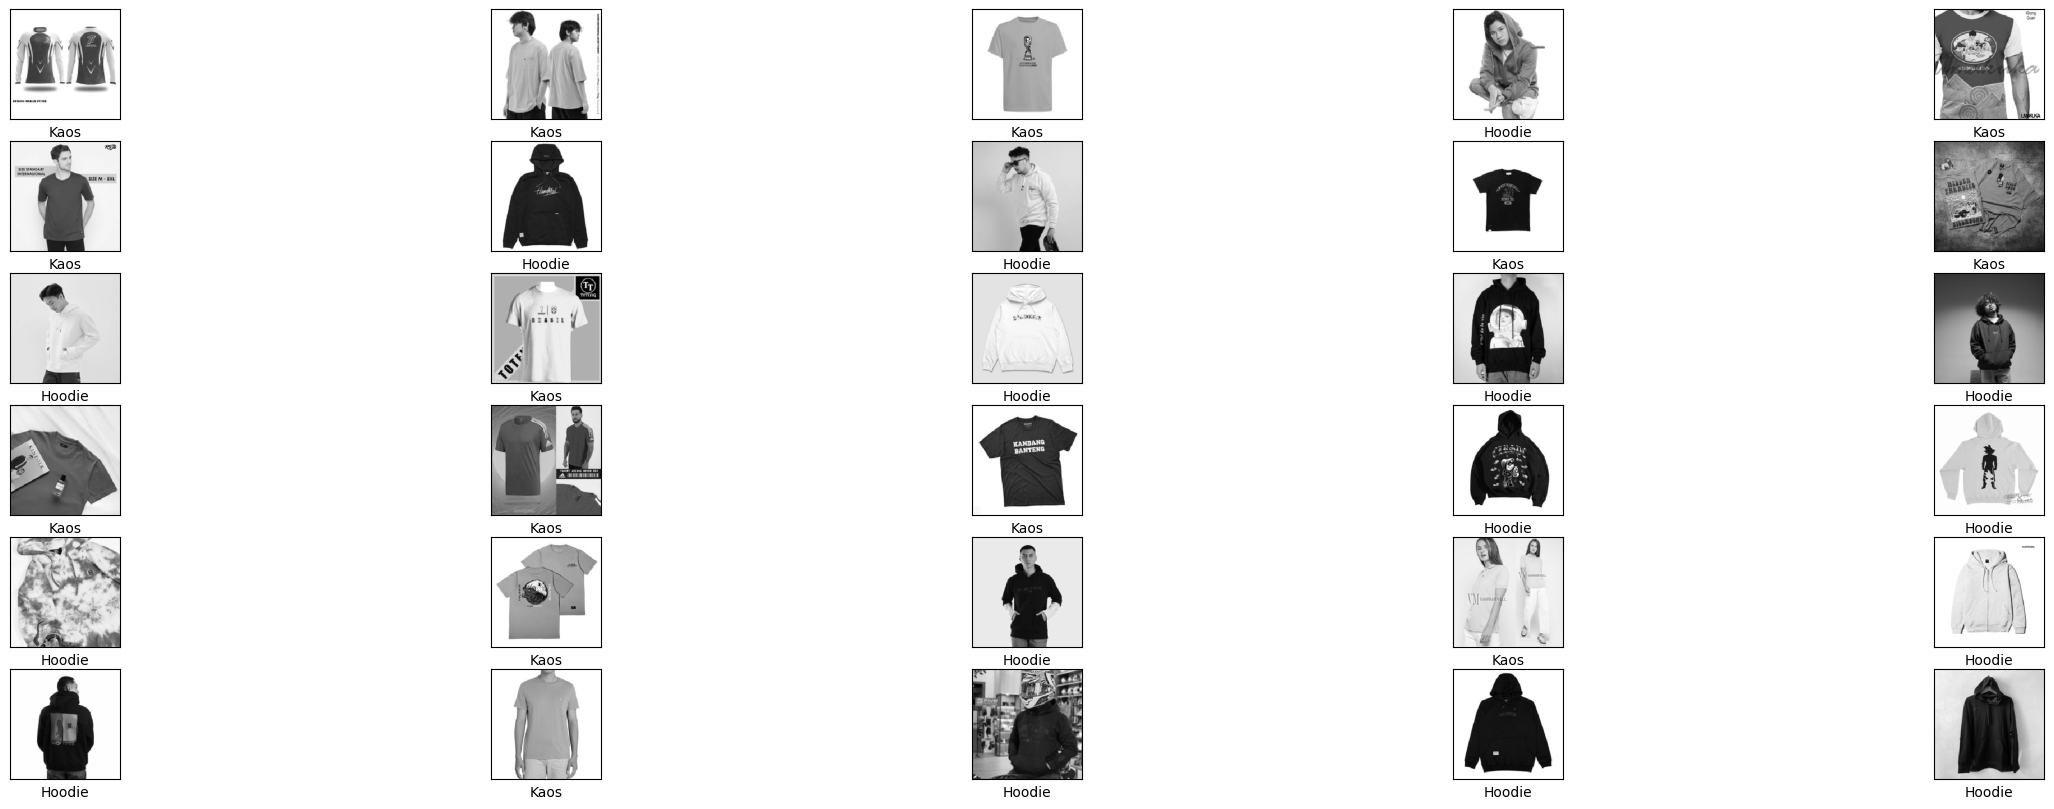

In [ ]:
plt.figure(figsize=(30, 10))
for i in range(30):
    plt.subplot(6, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_gray_train[i], cmap='gray')
    plt.xlabel(index_to_shape_dict[Y_shape_train[i]])
plt.show()

In [ ]:
model = Sequential([
    Conv2D(64, (2, 2), activation='relu', input_shape=SHAPE_CLASSIFIER_INPUT_SHAPE),
    Conv2D(64, (2, 2), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (2, 2), activation='relu'),
    Conv2D(128, (2, 2), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(256, (2, 2), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    MaxPooling2D(2, 2),

    Flatten(),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 223, 223, 64)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 222, 222, 64)        │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 110, 110, 128)       │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 109, 109, 128)       │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 53, 53, 256)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 173056)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      11,075,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,322,369 (43.19 MB)

 Trainable params: 11,322,369 (43.19 MB)

 Non-trainable params: 0 (0.00 B)

Train model

In [ ]:
epochs = 30

history = model.fit(X_gray_train, Y_shape_train,
                    validation_data=(X_gray_val, Y_shape_val),
                    epochs=epochs)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 935ms/step - accuracy: 0.5174 - loss: 2.1915 - val_accuracy: 0.5323 - val_loss: 1.5527
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.5651 - loss: 1.4040 - val_accuracy: 0.7419 - val_loss: 0.9593
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.7045 - loss: 0.8984 - val_accuracy: 0.7097 - val_loss: 0.7252
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - accuracy: 0.7762 - loss: 0.6655 - val_accuracy: 0.8065 - val_loss: 0.5605
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.8261 - loss: 0.4950 - val_accuracy: 0.7742 - val_loss: 0.5160
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - accuracy: 0.8688 - loss: 0.4165 - val_accuracy: 0.7581 - val_loss: 0.5227
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.8514 - loss: 0.3678 - val_accuracy: 0.8065 - val_loss: 0.4896
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.8781 - loss: 0.3019 - val_accuracy: 0

Analyze model result

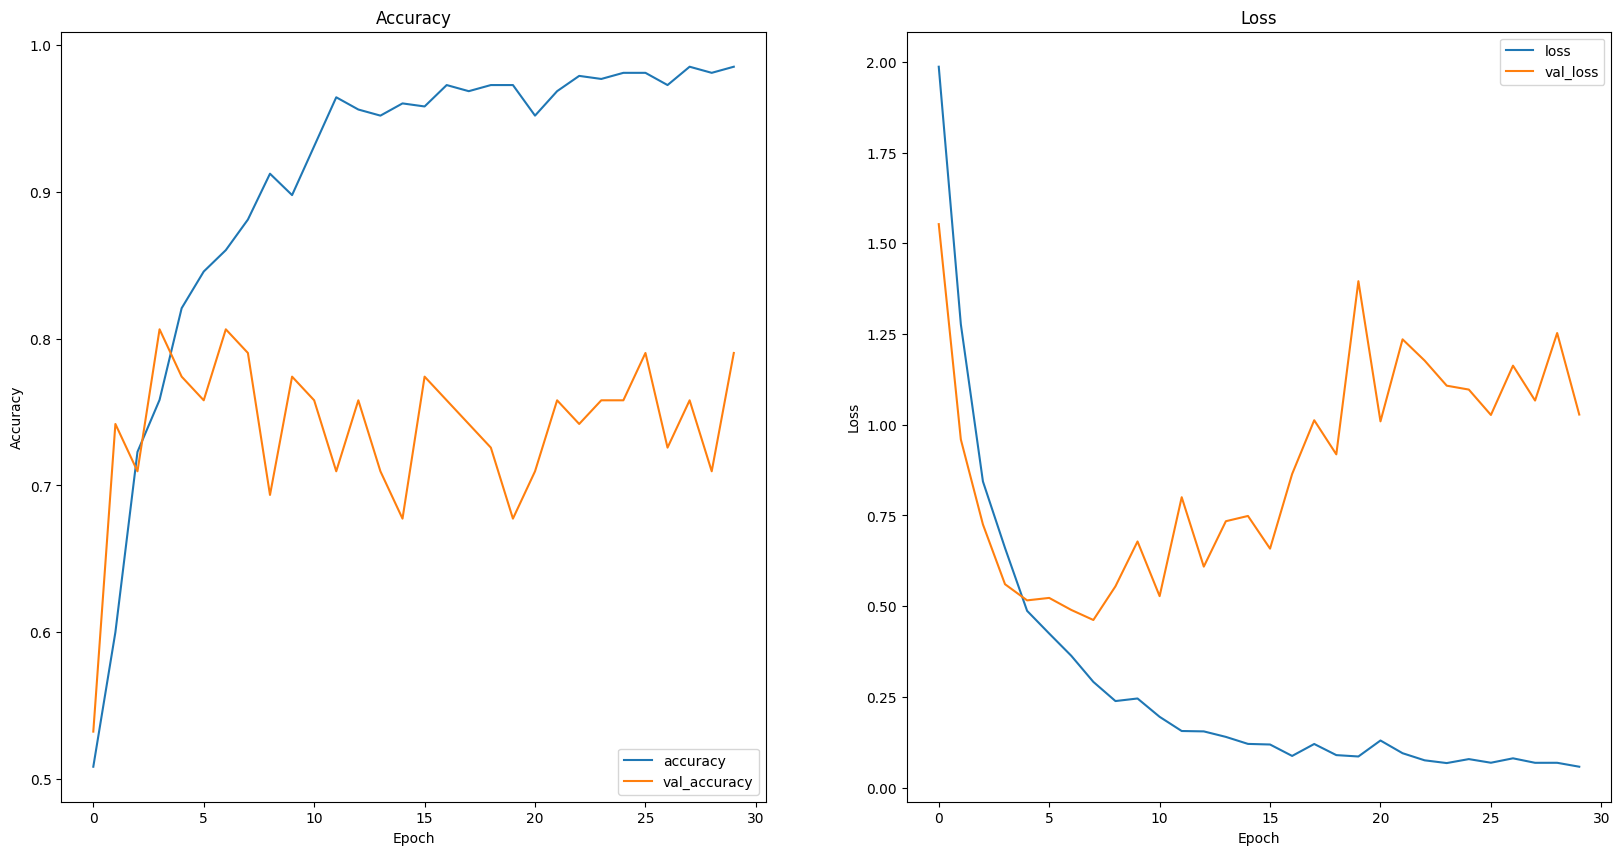

In [ ]:
# Plot accuracy and loss

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Loss")

plt.show()

In [ ]:
# Print test accuracy
test_loss, test_accuracy = model.evaluate(X_gray_test, Y_shape_test)

print(f"Test accuracy: {test_accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.7389 - loss: 1.3451
Test accuracy: 0.7333333492279053


Load submission data

In [ ]:
# Load to-be-predicted Images
X_to_be_predicted = []

TEST_IMG_PATH = directory_header + "dataset/test/"

target_size = (224, 224)


for idx, file in enumerate(os.listdir(TEST_IMG_PATH)):

    file_path = os.path.join(TEST_IMG_PATH, file)

    # Load data in RGB format for color classification
    image = tf.keras.preprocessing.image.load_img(
        file_path, color_mode="grayscale", target_size=target_size
    )
    image = tf.keras.preprocessing.image.img_to_array(image)

    X_to_be_predicted.append(image)


# Convert to numpy array for easier manipulation
X_to_be_predicted = np.array(X_to_be_predicted)

print(X_to_be_predicted[0])

[[[67.]
  [68.]
  [69.]
  ...
  [68.]
  [68.]
  [68.]]

 [[66.]
  [67.]
  [68.]
  ...
  [68.]
  [68.]
  [68.]]

 [[67.]
  [67.]
  [69.]
  ...
  [68.]
  [68.]
  [68.]]

 ...

 [[44.]
  [43.]
  [43.]
  ...
  [36.]
  [36.]
  [37.]]

 [[43.]
  [43.]
  [42.]
  ...
  [35.]
  [35.]
  [36.]]

 [[43.]
  [43.]
  [42.]
  ...
  [34.]
  [34.]
  [35.]]]


In [ ]:
# Predict untrained data

X_to_be_predicted_normalized = X_to_be_predicted / 255

prediction_result = model.predict(X_to_be_predicted_normalized)
print(prediction_result.shape)

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step
(334, 1)


In [ ]:
prediction_result_class = [0 if prediction < 0.5 else 1 for prediction in prediction_result]
print(prediction_result_class)

[1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 